<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/Diffusion_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1D Diffusion**

This notebook validates the Fokker-Planck like equation derived in the paper Craske J. et al. 2024 by computing each of the relevant terms numerically for the case of 1D scalar diffusion on a bounded domain. To solve this equation we use the open source pseudo-spectral code Dedalus.

**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [152]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)



**Content**

First let's import everything we need to run the rest of the notebook.

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)
#%matplotlib widget

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'


Next we write a solver for the equation for the scalar concentration
\begin{equation}
\partial_t C = \kappa \partial_z^2 C, \quad z \in [0,1],
\end{equation}
over the time interval $t \in [0,1]$ subject to the Robin boundary conditions
\begin{aligned}
 \Gamma C - \beta \partial_z C &= g_0(t), \quad \text{at} \quad z = 0, \\
 \Gamma C + \beta \partial_z C &= g_1(t), \quad \text{at} \quad z = 1,
\end{aligned}
for the initial condition
\begin{equation}
C(z,t=0) = \sin(2 \pi z)
\end{equation}

In [154]:
# Boundary conditions
def g_0(t):
    return -1;
def g_1(t):
    return  1;

# Solver
def Solve(β, Γ, κ, Nz=512):

  stop_sim_time = .125*(1/κ) # Less than a diffusion time so not a steady state solution
  timestep      = 1e-03

  zcoord = d3.Coordinate('z')
  dist   = d3.Distributor(zcoord, dtype=np.float64)
  zbasis = d3.ChebyshevT(zcoord, size=Nz, bounds=(0,1),dealias=3/2)

  # Fields
  C      = dist.Field(name='c', bases=zbasis)
  tau_c1 = dist.Field(name='tau_c1')
  tau_c2 = dist.Field(name='tau_c2')
  g0     = dist.Field(name='g0')
  g1     = dist.Field(name='g1')

  # Substitutions
  dz = lambda A: d3.Differentiate(A, zcoord)
  lift_basis = zbasis.derivative_basis(1)
  lift = lambda A: d3.Lift(A, lift_basis, -1)
  Cz = dz(C)  + lift(tau_c1)
  Czz= dz(Cz) + lift(tau_c2)

  # Problem
  problem = d3.IVP([C, tau_c1, tau_c2], namespace=locals())
  problem.add_equation("dt(C) - κ*Czz = 0")
  problem.add_equation("Γ*C(z=0) - β*dz(C)(z=0) = g0")
  problem.add_equation("Γ*C(z=1) + β*dz(C)(z=1) = g1")

  # Solver
  solver = problem.build_solver(d3.RK222)
  solver.stop_sim_time = stop_sim_time

  # Initial condition
  z      = dist.local_grid(zbasis)
  C['g'] = np.sin(2.*np.pi*z)

  # Flow properties
  flow = d3.GlobalFlowProperty(solver, cadence=500)
  flow.add_property(d3.Integrate(C**2) , name='<C^2>')
  flow.add_property(d3.Integrate(Cz**2), name='<Cz^2>')

  # Main loop
  logger.info('Starting main loop')
  while solver.proceed:

      # Specify the bcs
      g0['g'] = g_0(solver.sim_time)
      g1['g'] = g_1(solver.sim_time)

      solver.step(timestep)
      if (solver.iteration-1) % int(stop_sim_time/(4.*timestep)) == 0:

          C2_avg  = flow.grid_average('<C^2>')
          Cz2_avg = flow.grid_average('<Cz^2>')

          # logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
          # logger.info('<C^2>=%f, <Cz^2>    =%f'%(C2_avg,Cz2_avg))

      # Capture the last 5 snapshots
      if  solver.iteration == int(stop_sim_time/timestep) - 5:
          snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
          snapshots.add_task(C , layout='g',name='C' ,scales=3/2)
          snapshots.add_task(Cz, layout='g',name='Cz',scales=3/2)

  return None

**Fokker-Planck like equation**

Having time integrated the transport equation for the solute concentration and generated snapshots of $C(z;t)$ at discrete time intervals on our numerical grid, we now use this data to validate the Fokker-Planck like equation
\begin{equation}
\partial_tf_{C|Z} = - \partial_c \left( \mathbb{E}[ \kappa \Delta C |C=c,Z=z]f_{C|Z} \right),
\end{equation}
which,in order to make the contribution of the boundary conditions more transparent, can also be written as
<!-- \begin{equation}
\partial_tf_C = -\partial_c \left( \mathbb{S}(c) f_C \right) - \kappa \partial^2_c \left( \mathbb{E}[ |\nabla C|^2 |C=c]f_C \right),
\end{equation}
or indeed  -->
\begin{equation}
\partial_tf_C = \int_0^1  \kappa \partial^2_z f_{C|Z} dz - \kappa \partial^2_c \left( \mathbb{E}[ |\nabla C|^2 |C=c]f_C \right).
\end{equation}
Subject to the knowledge of the source term arising from the boundary conditions and the expectation of the concentration gradient conditional on $C$ this equation governs the time evolution of the probability density $f_C(c;t)$. To see how we evaluate the source term and how this relates to the boundary conditions we begin by loading the numerical snapshots saved from the time-integration.

In [155]:
def Data(N_bins=128):

  # Data loading
  file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

  # Interpolate the data (t,z) from a Chebyshev grid onto a uniform grid
  C_cheb  = file['tasks/C' ][:,:]
  Cz_cheb = file['tasks/Cz'][:,:]
  z_cheb  = file['tasks/C'].dims[1][0][:]
  times   = file['tasks/C'].dims[0][0][:]

  dz_cheb = z_cheb[1]-z_cheb[0];
  z_data  = np.arange(0,1,dz_cheb);
  s       = (len(times),len(z_data));
  C_data  = np.zeros(s)
  Cz_data = np.zeros(s)
  for i,t in enumerate(times):
    C_data[i,:] = np.interp(z_data, z_cheb, C_cheb[i,:] )
    Cz_data[i,:]= np.interp(z_data, z_cheb, Cz_cheb[i,:])
  dC2_data = Cz_data**2;

  return times, z_data,C_data,Cz_data,dC2_data;

We then use these data to estimate the terms in the Fokker-Planck like equation. To evaluate the left hand side we esimate the PDF $f_C$ (as a histogram) and then take its time derivative $\partial_t f_C$ using 4th order central differencing.

In [156]:
def dfdt(times,C_data,N_bins=128):

  # PDF f_C
  f_np2,c = np.histogram(C_data[-1,...].flatten(),bins=N_bins,density=True); # n + 2 (-1)
  f_np1,c = np.histogram(C_data[-2,...].flatten(),bins=N_bins,density=True); # n + 1 (-2)

  f_nm1,c = np.histogram(C_data[-4,...].flatten(),bins=N_bins,density=True); # n - 1 (-4)
  f_nm2,c = np.histogram(C_data[-5,...].flatten(),bins=N_bins,density=True); # n - 2 (-5)

  c       = 0.5*(c[1:] + c[:-1]); dc = c[1] - c[0];

  # Time derivate df_C/dt
  dt   = times[-1] - times[-2];
  #dfdt = (-1./12.)*f_np2 + (2./3.)*f_np1 - (2./3.)*f_nm1 + (1./12.)*f_nm2;
  dfdt =                    (1./2.)*f_np1 - (1./2.)*f_nm1
  dfdt /=dt;

  return dfdt;

To obtain the right hand side we must compute the conditional expectation which we evaluate from its conditional probability
\begin{equation}
\mathbb{E}[ |\nabla C|^2 |C=c] = \int \phi \frac{ f_{ |\nabla C|^2|C}(\phi|c) }{f_C(c)} d \phi,
\end{equation}
as well as the derivative operator
\begin{equation}
L f^n \equiv \partial^2_c f^n = \frac{f^n_{i+1} - 2 f^n_{i} + f^n_{i-1}}{\Delta^2 c}
\end{equation}
for which we again avail of finite differences. Having used central differencing to estimate the time derivative centered at time index n=-3 we must evaluate this conditional expectation at the same index.

In [157]:
def EdC2(dC2_data,C_data,N_bins=128):

  # Expectation
  # Let Φ = |∇C|^2 and φ its dummy variable
  f_CΦ,c,φ = np.histogram2d(C_data[-3,...].flatten(), dC2_data[-3,...].flatten(),bins=N_bins,density=True) # n (-3)
  φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
  c = .5*(c[1:]+c[:-1]); dc = c[1] - c[0];
  f_C =  np.sum(  f_CΦ,axis=1)*dφ;      # f_C(c)
  E   = (np.sum(φ*f_CΦ,axis=1)*dφ)/f_C; # E{Φ|C} = int_φ f_Φ|C(φ|c)*φ dφ

  return E,f_C,c

def Laplacian(c):

  N = len(c)
  dc= c[1]-c[0]
  L = np.zeros((N,N))
  for i in range(N):

    if i == 0:
        L[i,i  ] = -2.
        L[i,i+1] =  1
    elif i == N-1:
        L[i,i-1] =  1.
        L[i,i  ] = -2
    else:
        L[i,i-1] =  1
        L[i,i  ] = -2.
        L[i,i+1] =  1

  L   *= 1./(dc**2);
  return L;

Evaluation of the source term is somewhat more involved. We being by making the following manipulations
\begin{equation} %-\frac{\partial }{\partial c} \left( \mathbb{S}(c) f_C \right)
\int_0^1 \frac{\partial^2 f_{C|Z} }{\partial z^2} dz  = -\frac{\partial }{\partial c} \left( \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C,Z \right\} f_{C|Z} \right)|_{Z=1,0},
\end{equation}
such that our boundary conditions simplifies to
\begin{equation}
\frac{\partial f_{C|Z} }{\partial z} |_{Z=1,0} = - \frac{\partial }{\partial c} \left( \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C,Z=1 \right\} f_{C|Z=1} - \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C,Z=0 \right\} f_{C|Z=0} \right),
\end{equation}
while we can write the conditional probabilities as
delta functions at $z=1,0$
\begin{equation}
f_{C|Z}(c|z=1) = \delta(c - C(Z=1)), \quad f_{C|Z}(c|z=0) = \delta(c - C(Z=0)).
\end{equation}
At this point we must split the conditional expectations according to the physical boundary conditions prescribed.

**Dirichlet $\beta = 0$**

For this case we know $C(z)$ on the boundaries but we do not know $C_z(z)$. The conditional expectations can be reduced to
\begin{equation}
\mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C=c,Z=1 \right\} = \mathbb{E} \left\{ \frac{\partial C}{\partial Z}  \middle| C = g_1/\Gamma,Z=1 \right\}, \quad \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C=c,Z=0 \right\} = \mathbb{E} \left\{ \frac{\partial C}{\partial Z}  \middle| C = g_0/\Gamma,Z=0 \right\}
\end{equation}
showing that the boundary term are known up to a constant multiple and must otherwise be estimated numerically.

**Neumann/Robin**

For this case we know $C_z(z)$ but do not know $C_z(z)$ on the boundaries. The conditional expectations reduce to
\begin{equation}
\mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C,Z=1 \right\} = \frac{g_1 - \Gamma c}{\beta}, \quad \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C,Z=0 \right\} = -\frac{g_0 - \Gamma c}{\beta}.
\end{equation}
which combined with the conditional probabilities above yields
\begin{equation}
\frac{\partial f_{C|Z} }{\partial z} |_{Z=1,0} = -\frac{\partial }{\partial c} \left( \delta(c - C(Z=1))  \left( \frac{g_1 - \Gamma c}{\beta} \right) + \delta(c - C(Z=0))  \left( \frac{g_0 - \Gamma c}{\beta} \right) \right).
\end{equation}
Hence in this case while we can evaluate the conditional expectation exactly we do not know the conditional PDF on the boundary.

**Numerical Comparison**

To compare the terms of the Fokker-Planck equation we opt to twice integrate equation

\begin{equation}
\kappa \mathbb{E}[ |\nabla C|^2 |C=c]f_C =  \iint \Bigg( \kappa \int_0^1 \partial^2_z f_{C|Z} dz \Bigg) dc dc -  \partial^{-2}_c \partial_tf_C ,
\end{equation}
where we treat the source term analytically using the fact that the fact that
\begin{equation}
\int y(c)\delta(c - a) dc = y(a)H(c - a) + const,
\end{equation}
where $H(x)$ denotes the heavisde step function, while for the time derivatoive we invert the 1D-Laplacian $\partial_c^2$ on to the right hand side.

We now outline these comparisons below for the two sets of boundary conditions specified.

<!-- Using the fact that
\begin{equation}
\int y(c)\delta(c - a) dc = y(a)H(c - a) + const,
\end{equation}
where $H(x)$ denotes the heavisde step function we can write
\begin{aligned}
    \int \frac{\partial f_{C|Z} }{\partial z} |_{Z=1,0} dc &=  H(c - C(Z=1)) \left( \frac{g_1 - C(Z=1)}{\beta} \right) + H(c - C(Z=0))  \left( \frac{g_0 - C(Z=0)}{\beta} \right) + const, \\
                                                           &= H(c - C(Z=0))  \left( \frac{g_0 - C(Z=0)}{\beta} \right),
\end{aligned}
as the first term is non-zero only outside the domain. A particularly simple case is the fixed flux boundary conditions
\begin{equation}
-\partial_z C(Z=0) = 1, \quad \partial_z C(Z=1) = 1,
\end{equation}
corresponding to a flux of concentration into and out of the domain at $Z=0, Z=1$ respectively, for which $\Gamma=0, \beta=1$ and $g_0 = g_1 = 1$. -->

In [158]:
def Compare_equation_terms(LHS,RHS,c):

  """
  Compares integrated

  LHS and RHS

  of the Fokker-Planck equation
  """

  error = np.trapz(LHS+RHS,c)
  print('\n ~~~~~~~~~~~ Fokker Planck Equation error ~~~~~~~~~~~~~~~~~~~~~~~~~~ ')
  print('Error between LHS and RHS = ',error)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n ')

  fig = plt.figure(figsize=(6,4))

  plt.plot(c,LHS,'r-',label=r'$\kappa \mathbb{E}[ |\nabla C|^2 |C=c] f_C$')
  plt.plot(c,RHS,'b-',label=r'$-\int \mathbb{S}(c) f_C dc -\partial_t \int \int f_C d\tilde{c} dc$')

  plt.xlabel(r'$c$')
  plt.legend(fontsize=20)
  plt.tight_layout()
  plt.savefig('Equation_terms_HIST.png',dpi=200)
  plt.show()

  return None;

def Plot_Solution_and_PDF(z_data,C_data,c,f_C,E):

  fig, axs = plt.subplots(1,3,figsize=(6,4))

  axs[0].plot(z_data,C_data[-1,:],'k')
  axs[0].set_xlim([0,1])
  axs[0].set_ylabel(r'$C(z)$')
  axs[0].set_xlabel(r'$z$')

  axs[1].plot(c,f_C,'r')
  axs[1].fill_between(x=c,y1=f_C,color= "r",alpha= 0.2)
  axs[1].set_ylabel(r'$f_C$')
  axs[1].set_xlabel(r'$c$')

  axs[2].plot(c,E,'r')
  axs[2].set_ylabel(r'$\mathbb{E}[|\nabla C|^2 |C=c]$')
  axs[2].set_xlabel(r'$c$')

  plt.tight_layout()
  plt.savefig('Field_And_PDF.png',dpi=200)
  plt.show()

  return None;

*Dirichelt Validation $\beta=0$*

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-04-08 11:36:26,334 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:__main__:Starting main loop


2024-04-08 11:36:26,341 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-04-08 11:36:27,238 solvers 0/1 INFO :: Simulation stop time reached.

 ~~~~~~~~~~~ Fokker Planck Equation error ~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Error between LHS and RHS =  0.03198070804154727
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 


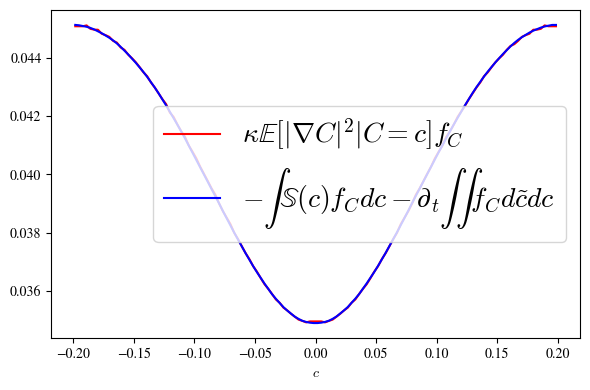

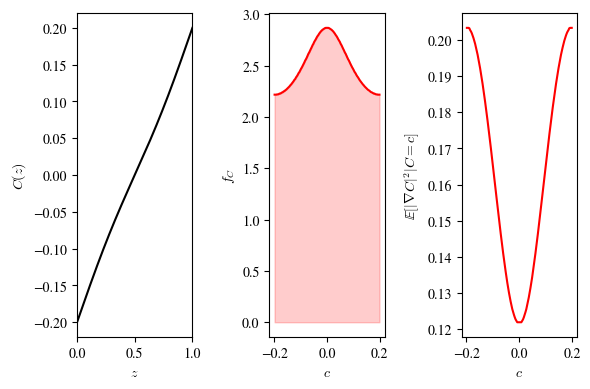

In [162]:
# Parameters
β = 0.0;
Γ = 5.0; κ = 0.1;

# Solve & grab the data
Solve(β, Γ, κ, Nz=512)
times, z_data,C_data,Cz_data,dC2_data = Data()

# Estimate the terms
df_cdt  = dfdt(times   ,C_data)
E,f_C,c = EdC2(dC2_data,C_data)

# Source term
file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')
Cz_cheb = file['tasks/Cz'][:,:]

intSf_C = 0.*c
intSf_C[:]  =-Cz_cheb[-3,  0] # C(z=0)

L   = Laplacian(c);
LHS =  κ*E*f_C
RHS = -κ*intSf_C - np.linalg.inv(L)@df_cdt

Compare_equation_terms(LHS,RHS,c)
Plot_Solution_and_PDF(z_data,C_data,c,f_C,E)

*Neumann Validation $\Gamma = 0$*

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2024-04-08 11:33:07,834 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


INFO:__main__:Starting main loop


2024-04-08 11:33:07,842 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-04-08 11:33:08,708 solvers 0/1 INFO :: Simulation stop time reached.

 ~~~~~~~~~~~ Fokker Planck Equation error ~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Error between LHS and RHS =  0.022037041576505288
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 


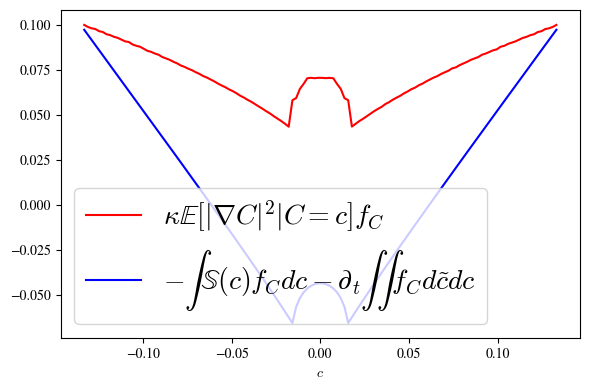

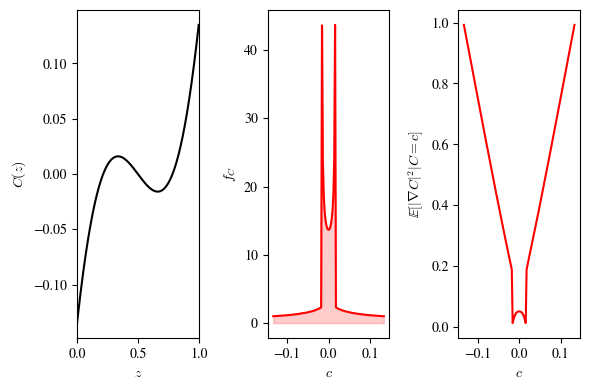

In [160]:
# Parameters
β = 1.0;
Γ = 0.0; κ = 0.1;

# Solve & grab the data
Solve(β, Γ, κ, Nz=512)
times, z_data,C_data,Cz_data,dC2_data = Data()

# Estimate the terms
df_cdt  = dfdt(times   ,C_data)
E,f_C,c = EdC2(dC2_data,C_data)

# Source term
file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')
C_cheb  = file['tasks/C' ][:,:]
int_Sf_C    = 0.*c
int_Sf_C[:] = (g_0(times[-3]) - Γ*C_cheb[-3, 0])/β;

L   = Laplacian(c);
LHS =  κ*E*f_C
RHS = -κ*int_Sf_C - np.linalg.inv(L)@df_cdt

Compare_equation_terms(LHS,RHS,c)
Plot_Solution_and_PDF(z_data,C_data,c,f_C,E)